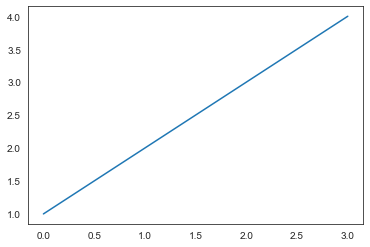

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pprint import pprint
%matplotlib inline
sns.set_style("white")
plt.plot(np.arange(1,5));

# USE ogbn-mag?

Outcome: 4% accuracy with 1 or 2hop (1 or 2 features) per node using only structure.


In [21]:
graph['node_feat_dict']['paper'][train_idx['paper']]

(629571, 128)

In [2]:
from ogb.nodeproppred import NodePropPredDataset

d_name = "ogbn-mag"
dataset = NodePropPredDataset(name = d_name)

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph, label = dataset[0]

In [3]:
print(f'Unique rels: {len(graph["edge_index_dict"].keys())}')
print(f"Unique nodes: {graph['node_feat_dict']['paper'].shape[0]}")

Unique rels: 4
Unique nodes: 736389


In [4]:
from ogb.nodeproppred import Evaluator

evaluator = Evaluator(name = d_name)
print(evaluator.expected_input_format)
print(evaluator.expected_output_format)


==== Expected input format of Evaluator for ogbn-mag
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_node, num_task)
- y_pred: numpy ndarray or torch tensor of shape (num_node, num_task)
where y_pred stores predicted class label (integer),
num_task is 1, and each row corresponds to one node.

==== Expected output format of Evaluator for ogbn-mag
{'acc': acc}
- acc (float): Accuracy score averaged across 1 task(s)



In [5]:
max(graph['edge_index_dict'][('author',
   'affiliated_with',
   'institution')][0])

1134648

In [34]:
#graph

{'edge_index_dict': {('author',
   'affiliated_with',
   'institution'): array([[      0,       1,       2, ..., 1134645, 1134647, 1134648],
         [    845,     996,    3197, ...,    5189,    4668,    4668]]),
  ('author',
   'writes',
   'paper'): array([[      0,       0,       0, ..., 1134647, 1134648, 1134648],
         [  19703,  289285,  311768, ...,  657395,  671118,  719594]]),
  ('paper',
   'cites',
   'paper'): array([[     0,      0,      0, ..., 736388, 736388, 736388],
         [    88,  27449, 121051, ..., 421711, 427339, 439864]]),
  ('paper',
   'has_topic',
   'field_of_study'): array([[     0,      0,      0, ..., 736388, 736388, 736388],
         [   145,   2215,   3205, ...,  21458,  22283,  31934]])},
 'edge_feat_dict': None,
 'node_feat_dict': {'paper': array([[-0.095379,  0.040758, -0.210948, ...,  0.061569, -0.027663,
          -0.133832],
         [-0.151047, -0.107315, -0.221964, ...,  0.345754, -0.027737,
          -0.218527],
         [-0.114799, -0.1759

In [6]:
from scipy.sparse import csc_matrix
from sympy import nextprime

relid2prime = {}
prime2relid = {}
current_int = 2

data_edges, rows, cols = [], [], []
N_nodes = sum(list(graph['num_nodes_dict'].values()))
for rel, indexes in graph['edge_index_dict'].items():
    cur_prime = int(nextprime(current_int))
    relid2prime[rel] = cur_prime
    prime2relid[cur_prime] = rel
    current_int = cur_prime

    rows.extend(indexes[0].tolist())
    cols.extend(indexes[1].tolist())
    data_edges.extend([cur_prime for _ in indexes[0]])

adj_ = csc_matrix((data_edges, (rows, cols)), dtype=int, shape=(N_nodes, N_nodes))

In [7]:
# 1-hop features
adj_copy = adj_.copy()
adj_copy.data = np.log(adj_copy.data)
sum_ = adj_copy.sum(axis=1)
print(f'Calculated 1-hop features')

Calculated 1-hop features


In [8]:
# 2-hop features
hop2 = adj_ * adj_
adj_copy = hop2.copy()
adj_copy.data = np.log(adj_copy.data)
sum_2 = adj_copy.sum(axis=1)
print(f'Calculated 2-hop features')

Calculated 2-hop features


In [ ]:
# 3-hop features
hop3 = hop2 * adj_
adj_copy = hop3.copy()
adj_copy.data = np.log(adj_copy.data)
sum_3 = adj_copy.sum(axis=1)
print(f'Calculated 3-hop features')

In [9]:
feats1 = sum_

In [10]:
feats2 = np.hstack((sum_, sum_2 - sum_))

In [ ]:
feats3 = np.hstack((sum_, sum_2 - sum_, sum_3 - sum_2 - sum1))

In [24]:
feats_node_emb_1_train =  np.hstack((sum_[train_idx['paper']],graph['node_feat_dict']['paper'][train_idx['paper']]))
feats_node_emb_1_test =  np.hstack((sum_[test_idx['paper']],graph['node_feat_dict']['paper'][test_idx['paper']]))

In [12]:
y_train = label['paper'][train_idx['paper'].flatten()].flatten()
y_test= label['paper'][test_idx['paper'].flatten()].flatten()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline([
    ('dt', RandomForestClassifier(n_jobs=-1, random_state=42))
    #('sd', StandardScaler()),
    #('clf', LinearSVC(C=100, class_weight='balanced'),)
])
pipe.fit(feats_node_emb_1_train, y_train)
print(f'Fitted')
y_pred = pipe.predict(feats_node_emb_1_test)
print(f'Predict')

In [ ]:
input_dict = {"y_true": y_test.reshape(-1,1),
              "y_pred": y_pred.reshape(-1,1)}
result_dict = evaluator.eval(input_dict)
print(result_dict)

In [46]:
feat = []
for i in tqdm.tqdm_notebook(train_idx['paper']):
    feat.append(np.sum(np.log(adj_[i].data)))
    #break

/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/629571 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [202]:
def get_prime_adjacency(dict_):
    """
    Helper function to create adjacency matrices with primes, using grakel dicts as input.
    Currently we only utilize the edges. The dict has key, values in the form of:
    (head, tail): relation
    :param dict_: dict, The dict has key, values in the form of (head, tail): relation .
    From grakel second argument per graph.
    :return adj: np.array, with the prime-transformed relation numbers
    """
    nodes = set()
    rels = set()
    for key, value in dict_.items():
        nodes.add(key[0])
        nodes.add(key[1])
        rels.add(value)

    nodes = sorted(nodes)
    id2node = {}
    node2id = {}
    for i, n in enumerate(nodes):
        id2node[i] = n
        node2id[n] = i

    rels = sorted(rels)
    from sympy import nextprime
    relid2prime = {}
    prime2relid = {}
    current_int = 2
    for rel in rels:
        cur_prime = nextprime(current_int)
        relid2prime[rel] = cur_prime
        prime2relid[cur_prime] = rel
        current_int = cur_prime

    adj = np.zeros((len(nodes), len(nodes)))
    for key, value in dict_.items():
        adj[node2id[key[0]], node2id[key[1]]] = relid2prime[value]
    return adj

prime_adj_all= [get_prime_adjacency(g[2]) for g in  G]
prime_adj_train = [get_prime_adjacency(g[2]) for g in  G_train]
prime_adj_test = [get_prime_adjacency(g[2]) for g in G_test]


In [203]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel, polynomial_kernel, cosine_similarity, chi2_kernel

class ProductPower(TransformerMixin):

    def __init__(self, power=1, normalize=False, grakel_compatible=True, kernel='rbf'):
        self.power = power
        self.normalize = normalize
        self.grakel_compatible = grakel_compatible
        self.kernel_str = kernel
        if self.kernel_str == 'rbf':
            self.kernel_fn = rbf_kernel
        elif self.kernel_str == 'linear':
            self.kernel_fn = linear_kernel
        elif self.kernel_str == 'cosine':
            self.kernel_fn = cosine_similarity
        elif self.kernel_str == 'chi2':
            self.kernel_fn = chi2_kernel
        else:
            raise AttributeError(f'Kernel {self.kernel_str} is not understood!')
        self.x_train = None
        self.max_ = 1



        #self.decompose = PCA(n_components='mle')

    def fit(self, X, y=None):
        x_tr = []
        for x in X:
            try:
                max_array = np.max(x)
            except ValueError:
                # this is for empty adjacency like TOX21_AR
                x_tr.append(np.array([0 for _ in range(self.power)]))
                continue
            if max_array > self.max_:
                self.max_ = max_array
            if self.grakel_compatible:
                n = x.shape[0]
                cur_feat = []
                cur_x = x.copy()
                # Power = 0 (1-hop, original Adjacency)
                cur_prod = np.sum(np.log(cur_x[cur_x >0]))

                if self.normalize:
                    cur_prod = cur_prod / ((n**2)*np.log(self.max_))
                cur_feat.append(cur_prod)
                for p in range(1, self.power):
                    cur_x = np.matmul(cur_x, x)
                    cur_prod = np.sum(np.log(cur_x[cur_x >0]))
                    if self.normalize:
                        cur_prod = cur_prod / ((n**2)*np.log(self.max_**p))
                    cur_prod -= cur_feat[-1]
                    cur_feat.append(cur_prod)
                x_tr.append(np.array(cur_feat))
        if self.grakel_compatible:
            x_tr = np.array(x_tr)
            self.x_train = x_tr#self.kernel_fn(x_tr, x_tr)#x_tr
        #print(self.x_train.shape)
        return self

    def transform(self, X):
        x_tr = []
        for x in X:
            n = x.shape[0]
            if n == 0:
                x_tr.append(np.array([0 for _ in range(self.power)]))
                continue
            cur_feat = []
            cur_x = x.copy()
            # Power = 0 (1-hop, original Adjacency)
            cur_prod = np.sum(np.log(cur_x[cur_x >0]))
            if self.normalize:
                cur_prod = cur_prod / ((n**2)*np.log(self.max_))
            cur_feat.append(cur_prod)
            for p in range(1, self.power):
                cur_x = np.matmul(cur_x, x)
                cur_prod = np.sum(np.log(cur_x[cur_x >0]))
                if self.normalize:
                    cur_prod = cur_prod / ((n**2)*np.log(self.max_**p))
                cur_prod -= cur_feat[-1]
                cur_feat.append(cur_prod)
            x_tr.append(np.array(cur_feat))
        x_tr = np.array(x_tr)
        if self.grakel_compatible:
            #print('TRANFORM: ', x_tr.shape, self.x_train.shape)
            x_tr_orig = x_tr.copy()
            gamma = 1 / (x_tr.shape[1] * self.x_train.var())
            x_tr = self.kernel_fn(x_tr, self.x_train, gamma=gamma)
            #X_diag = np.einsum('ij,ij->i', self.x_train, self.x_train)
            #Y_diag = np.einsum('ij,ij->i', x_tr_orig, x_tr_orig)
            #print(X_diag.shape, Y_diag.shape)
            #print(np.outer(Y_diag, X_diag).shape)
            #print(x_tr.shape)
            #x_tr /= np.sqrt(np.outer(Y_diag, X_diag))
        return x_tr

pp = ProductPower(power=3, normalize=False, grakel_compatible=False, kernel='rbf')
X_train = pp.fit_transform(prime_adj_train, y_train)
X_test = pp.transform(prime_adj_test)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy PP:", str(round(acc*100, 2)) + "%")

Accuracy PP: 83.87%


In [213]:
from sklearn.decomposition import TruncatedSVD, IncrementalPCA

class Decomposer(TransformerMixin):

    def __init__(self, power=1, n_components=10, grakel_compatible=True, kernel='rbf'):
        self.power = power
        self.n_components = n_components
        self.decomposition_method = IncrementalPCA
        self.grakel_compatible = grakel_compatible
        self.kernel_str = kernel
        if self.kernel_str == 'rbf':
            self.kernel_fn = rbf_kernel
        elif self.kernel_str == 'linear':
            self.kernel_fn = linear_kernel
        elif self.kernel_str == 'cosine':
            self.kernel_fn = cosine_similarity
        elif self.kernel_str == 'chi2':
            self.kernel_fn = chi2_kernel
        else:
            raise AttributeError(f'Kernel {self.kernel_str} is not understood!')
        self.x_train = None



        #self.decompose = PCA(n_components='mle')

    def fit(self, X, y=None):
        x_tr = []
        if self.grakel_compatible:
            for x in X:
                n = x.shape[0]
                cur_feat = []
                cur_x = x.copy()
                # Power = 0 (1-hop, original Adjacency)
                cur_components = self.n_components if self.n_components < cur_x.shape[1] else cur_x.shape[1] - 1
                td = self.decomposition_method(cur_components)
                _ = td.fit_transform(cur_x)
                cur_prod = td.singular_values_[:cur_components]
                cur_feat.append(cur_prod)
                for p in range(1, self.power):
                    cur_x = np.matmul(cur_x, x)
                    cur_components = self.n_components if self.n_components < cur_x.shape[1] else cur_x.shape[1] - 1
                    td = self.decomposition_method(cur_components)
                    _ = td.fit_transform(cur_x)
                    cur_prod = td.singular_values_[:cur_components]
                    cur_feat.append(cur_prod)
                x_tr.append(np.array(cur_feat).flatten())
            x_tr = np.array(x_tr)
            self.x_train = x_tr#self.kernel_fn(x_tr, x_tr)#x_tr
        #print(self.x_train.shape)
        return self

    def transform(self, X):
        x_tr = []
        for x in X:
            n = x.shape[0]
            if n == 0:
                x_tr.append(np.array([0 for _ in range(self.power)]))
                continue
            cur_feat = []
            cur_x = x.copy()
            # Power = 0 (1-hop, original Adjacency)
            td = self.decomposition_method(self.n_components)
            _ = td.fit_transform(cur_x)
            cur_prod = td.singular_values_[:self.n_components]
            cur_feat.append(cur_prod)
            for p in range(1, self.power):
                cur_x = np.matmul(cur_x, x)
                td = self.decomposition_method(self.n_components)
                _ = td.fit_transform(cur_x)
                cur_prod = td.singular_values_[:self.n_components]
                cur_feat.append(cur_prod)
            x_tr.append(np.array(cur_feat).flatten())
        x_tr = np.array(x_tr)
        if self.grakel_compatible:
            #print('TRANFORM: ', x_tr.shape, self.x_train.shape)
            x_tr_orig = x_tr.copy()
            gamma = 1 / (x_tr.shape[1] * self.x_train.var())
            x_tr = self.kernel_fn(x_tr, self.x_train, gamma=gamma)
            #X_diag = np.einsum('ij,ij->i', self.x_train, self.x_train)
            #Y_diag = np.einsum('ij,ij->i', x_tr_orig, x_tr_orig)
            #print(X_diag.shape, Y_diag.shape)
            #print(np.outer(Y_diag, X_diag).shape)
            #print(x_tr.shape)
            #x_tr /= np.sqrt(np.outer(Y_diag, X_diag))
        return x_tr


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

dd = Decomposer(power=3, n_components=2, grakel_compatible=False, kernel='rbf')
X_train = dd.fit_transform(prime_adj_train, y_train)
X_test = dd.transform(prime_adj_test)

clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy Decomp:", str(round(acc*100, 2)) + "%")


Accuracy Decomp: 87.1%


In [200]:
print(len(X_train), len(y_train))

1600 1800


In [181]:


from grakel.datasets import fetch_dataset
from grakel.utils import cross_validate_Kfold_SVM
from grakel.kernels import WeisfeilerLehman, VertexHistogram
import time

# Loads the MUTAG dataset
dataset = fetch_dataset("AIDS", verbose=False)
G, y = dataset.data, dataset.target

# Generates a list of kernel matrices using the Weisfeiler-Lehman subtree kernel
# Each kernel matrix is generated by setting the number of iterations of the
# kernel to a different value (from 2 to 7)
time_s  = time.time()
Ks = list()
for i in range(1, 7):
    gk = WeisfeilerLehman(n_iter=i, base_graph_kernel=VertexHistogram, normalize=True)
    K = gk.fit_transform(G)
    Ks.append(K)
time_k = time.time()
print(f'Took {time_k - time_s:.5f} second to calculate the kernels!')

# Performs 10-fold cross-validation over different kernels and the parameter C of
# SVM and repeats the experiment 10 times with different folds
accs = cross_validate_Kfold_SVM([Ks], y, n_iter=10)
print("Average accuracy:", str(round(np.mean(accs[0])*100, 2)) + "%")
print("Standard deviation:", str(round(np.std(accs[0])*100, 2)) + "%")
time_e = time.time()
print(f'Took {time_e - time_k:.1f} second to gridsearch!')
print(f'Total time: {time_e - time_s:.1f}')

Took 5.67712 second to calculate the kernels!


KeyboardInterrupt: 

In [ ]:
time_s  = time.time()
Ks = list()
for i in range(1, 5):
    gk = ProductPower(power=i, normalize=False, grakel_compatible=True, kernel='rbf')
    K = gk.fit_transform(prime_adj_all, _)
    Ks.append(K)
time_k = time.time()
print(f'Took {time_k - time_s:.5f} second to calculate the kernels!')

# Performs 10-fold cross-validation over different kernels and the parameter C of
# SVM and repeats the experiment 10 times with different folds
accs = cross_validate_Kfold_SVM([Ks], y, n_iter=10)
print("Average accuracy:", str(round(np.mean(accs[0])*100, 2)) + "%")
print("Standard deviation:", str(round(np.std(accs[0])*100, 2)) + "%")
time_e = time.time()
print(f'Took {time_e - time_k:.1f} second to gridsearch!')
print(f'Total time: {time_e - time_s:.1f}')

# Compare with Grakel library Kernels

# Paper : https://grlplus.github.io/papers/79.pdf

In [503]:


from grakel.datasets.base import dataset_metadata

# We want edge labels as these are the multi-relational
# We need node labels for the other methodologies
# Tox datasets seem to have problems
wanted_dataset_names = []
for dataset_name, values in dataset_metadata.items():
    if values['el'] and values['nl'] and not('Tox' in dataset_name):
        wanted_dataset_names.append(dataset_name)

# Tox21_AHR has an empty graph,
# Tox21_AR is wronly packaged (the downloaded file after unzipping is named something else and throws error
unwanted = set(['Cuneiform', 'Tox21_AHR', 'Tox21_AR'])
wanted_dataset_names =[dt for dt in wanted_dataset_names if not(dt in unwanted)]
print(f'Total: {len(wanted_dataset_names)} datasets')
for dt in wanted_dataset_names:
    print(dt)

Total: 11 datasets
AIDS
BZR_MD
COX2_MD
DHFR_MD
ER_MD
Mutagenicity
MUTAG
PTC_FM
PTC_FR
PTC_MM
PTC_MR


In [504]:
import time
from grakel.kernels import WeisfeilerLehman, VertexHistogram, WeisfeilerLehmanOptimalAssignment, GraphletSampling
from sklearn.metrics import f1_score, accuracy_score

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

models = [
    #VertexHistogram(normalize=True),
    ShortestPath(normalize=True),
    WeisfeilerLehman(n_iter=1, base_graph_kernel=VertexHistogram, normalize=True),
    WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True),
    WeisfeilerLehmanOptimalAssignment(),
    GraphletSampling(),
    #ProductPower(power=1, grakel_compatible=False),
    ProductPower(power=1, normalize=False, grakel_compatible=False),
    #ProductPower(power=2, grakel_compatible=False),
    ProductPower(power=3, normalize=False, grakel_compatible=False),
    Decomposer(power=1, n_components=2, grakel_compatible=False),
    Decomposer(power=3, n_components=2, grakel_compatible=False),
    Decomposer(power=5, n_components=2, grakel_compatible=False),
    #ProductPower(power=5, grakel_compatible=False),
    #ProductPower(power=10, grakel_compatible=False),
]

model_names = [
    'SP',
    'WL-1',
    'WL-4',
    'WL-OA',
    'GR',
    'PP-1',
    'PP-1NN',
    'PP-3NN',
    'DD-1_2',
    'DD-3_2',
    'DD-5_2',
    # 'PP-5',
    # 'PP-10',
]

results = []
for dataset_name in wanted_dataset_names[:]:
    print(f'Dataset: {dataset_name}')
    dataset = fetch_dataset(dataset_name, verbose=False, download_if_missing=True)
    G, y = dataset.data, dataset.target
    # Splits the dataset into a training and a test set
    G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42, stratify=y)
    prime_adj_all = [get_prime_adjacency(g[2]) for g in  G]
    #prime_adj_train = [get_prime_adjacency(g[2]) for g in  G_train]
    #prime_adj_test = [get_prime_adjacency(g[2]) for g in G_test]
    for model, model_name in zip(models, model_names):
        #print(model_name)
        time_s = time.time()
        if 'PP' in model_name or 'DD' in model_name:
            #clf = SVC(kernel="rbf")
            X = prime_adj_all
            X = model.fit_transform(X)
            #K_train = model.fit_transform(X_train)
            #K_test = model.transform(X_test)
            pipe = Pipeline([
                ('sd', StandardScaler()),
                ('clf', SVC(kernel="rbf", class_weight='balanced'),)
            ])
        else:
            #clf = SVC(kernel="precomputed")
            #X_train = G_train
            #X_test = G_test
            X = G
            X = model.fit_transform(G)
            pipe = Pipeline([
  #              ('sd', MinMaxScaler()),
                ('clf', SVC(kernel="precomputed",  class_weight='balanced'))
            ])
        #            # K_train = model.fit_transform(X_train)
            # K_test = model.transform(X_test)
        # clf.fit(K_train, y_train)
        # y_pred = clf.predict(K_test)
        # acc = accuracy_score(y_test, y_pred)
        # f1 = f1_score(y_test, y_pred)
        scores = cross_validate(pipe, X=X, y=y, cv=10, scoring=['accuracy', 'f1_macro', 'f1_micro'], n_jobs=-1)
        time_took = time.time() - time_s
        results.append({'Dataset':dataset_name,
                        'Model':model_name,
                        'Acc':np.mean(scores['test_accuracy']),
                        'Acc_std':np.std(scores['test_accuracy']),
                        'F1_macro':np.mean(scores['test_f1_macro']),
                        'F1_macro_std':np.std(scores['test_f1_macro']),
                        'F1_micro':np.mean(scores['test_f1_micro']),
                        'F1_micro_std':np.std(scores['test_f1_micro']),
                        'Time':time_took})
        print(results[-1])
    print('~'*20)

Dataset: AIDS
{'Dataset': 'AIDS', 'Model': 'SP', 'Acc': 0.9875, 'Acc_std': 0.007158910531638183, 'F1_macro': 0.9807184094861855, 'F1_macro_std': 0.011019986071614819, 'F1_micro': 0.9875, 'F1_micro_std': 0.007158910531638183, 'Time': 9.1751549243927}
{'Dataset': 'AIDS', 'Model': 'WL-1', 'Acc': 0.8365, 'Acc_std': 0.026081602711489942, 'F1_macro': 0.7934727642081085, 'F1_macro_std': 0.02861383779070345, 'F1_micro': 0.8365, 'F1_micro_std': 0.026081602711489925, 'Time': 1.441014051437378}
{'Dataset': 'AIDS', 'Model': 'WL-4', 'Acc': 0.9734999999999999, 'Acc_std': 0.010965856099730664, 'F1_macro': 0.9588865619205388, 'F1_macro_std': 0.016833584014437877, 'F1_micro': 0.9734999999999999, 'F1_micro_std': 0.010965856099730664, 'Time': 1.5487160682678223}


KeyboardInterrupt: 

In [ ]:
res = pd.DataFrame(results)
res['dataset_rank'] = res.groupby(['Dataset'])['F1_macro'].rank(ascending=False)
res.groupby('Model').mean().sort_values('dataset_rank')



In [ ]:
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="Time", col="Dataset", hue="Model", sharey=False, col_wrap=3,
                data=res[['Dataset', 'Model', 'Time']], saturation=.5, height=10,
                kind="bar", ci=None, aspect=.6)

In [229]:
res['dataset_rank'] = res.groupby(['Dataset'])['F1_macro'].rank(ascending=False)
res.groupby('Model').mean().sort_values('dataset_rank')

,Acc,Acc_std,F1_macro,F1_macro_std,F1_micro,F1_micro_std,Time,dataset_rank
Model,,,,,,,,
WL-4,0.675022,0.071646,0.634889,0.076765,0.675022,0.071646,0.943802,3.909091
PP-3NN,0.637229,0.089332,0.614441,0.093910,0.637229,0.089332,0.775307,4.181818
PP-1,0.637469,0.091544,0.618054,0.094678,0.637469,0.091544,0.759508,4.409091
PP-1NN,0.637469,0.091544,0.618054,0.094678,0.637469,0.091544,0.736048,4.409091
WL,0.653319,0.081684,0.602132,0.090837,0.653319,0.081684,0.629704,5.090909
DD-3_2,0.632309,0.080210,0.597985,0.085025,0.632309,0.080210,1.836068,5.272727
DD-5_2,0.622235,0.087315,0.604311,0.092355,0.622235,0.087315,2.599732,5.272727
DD-1_2,0.634635,0.090121,0.588775,0.093750,0.634635,0.090121,1.122694,5.363636
VH,0.587158,0.081262,0.520128,0.093675,0.587158,0.081262,0.437456,7.090909


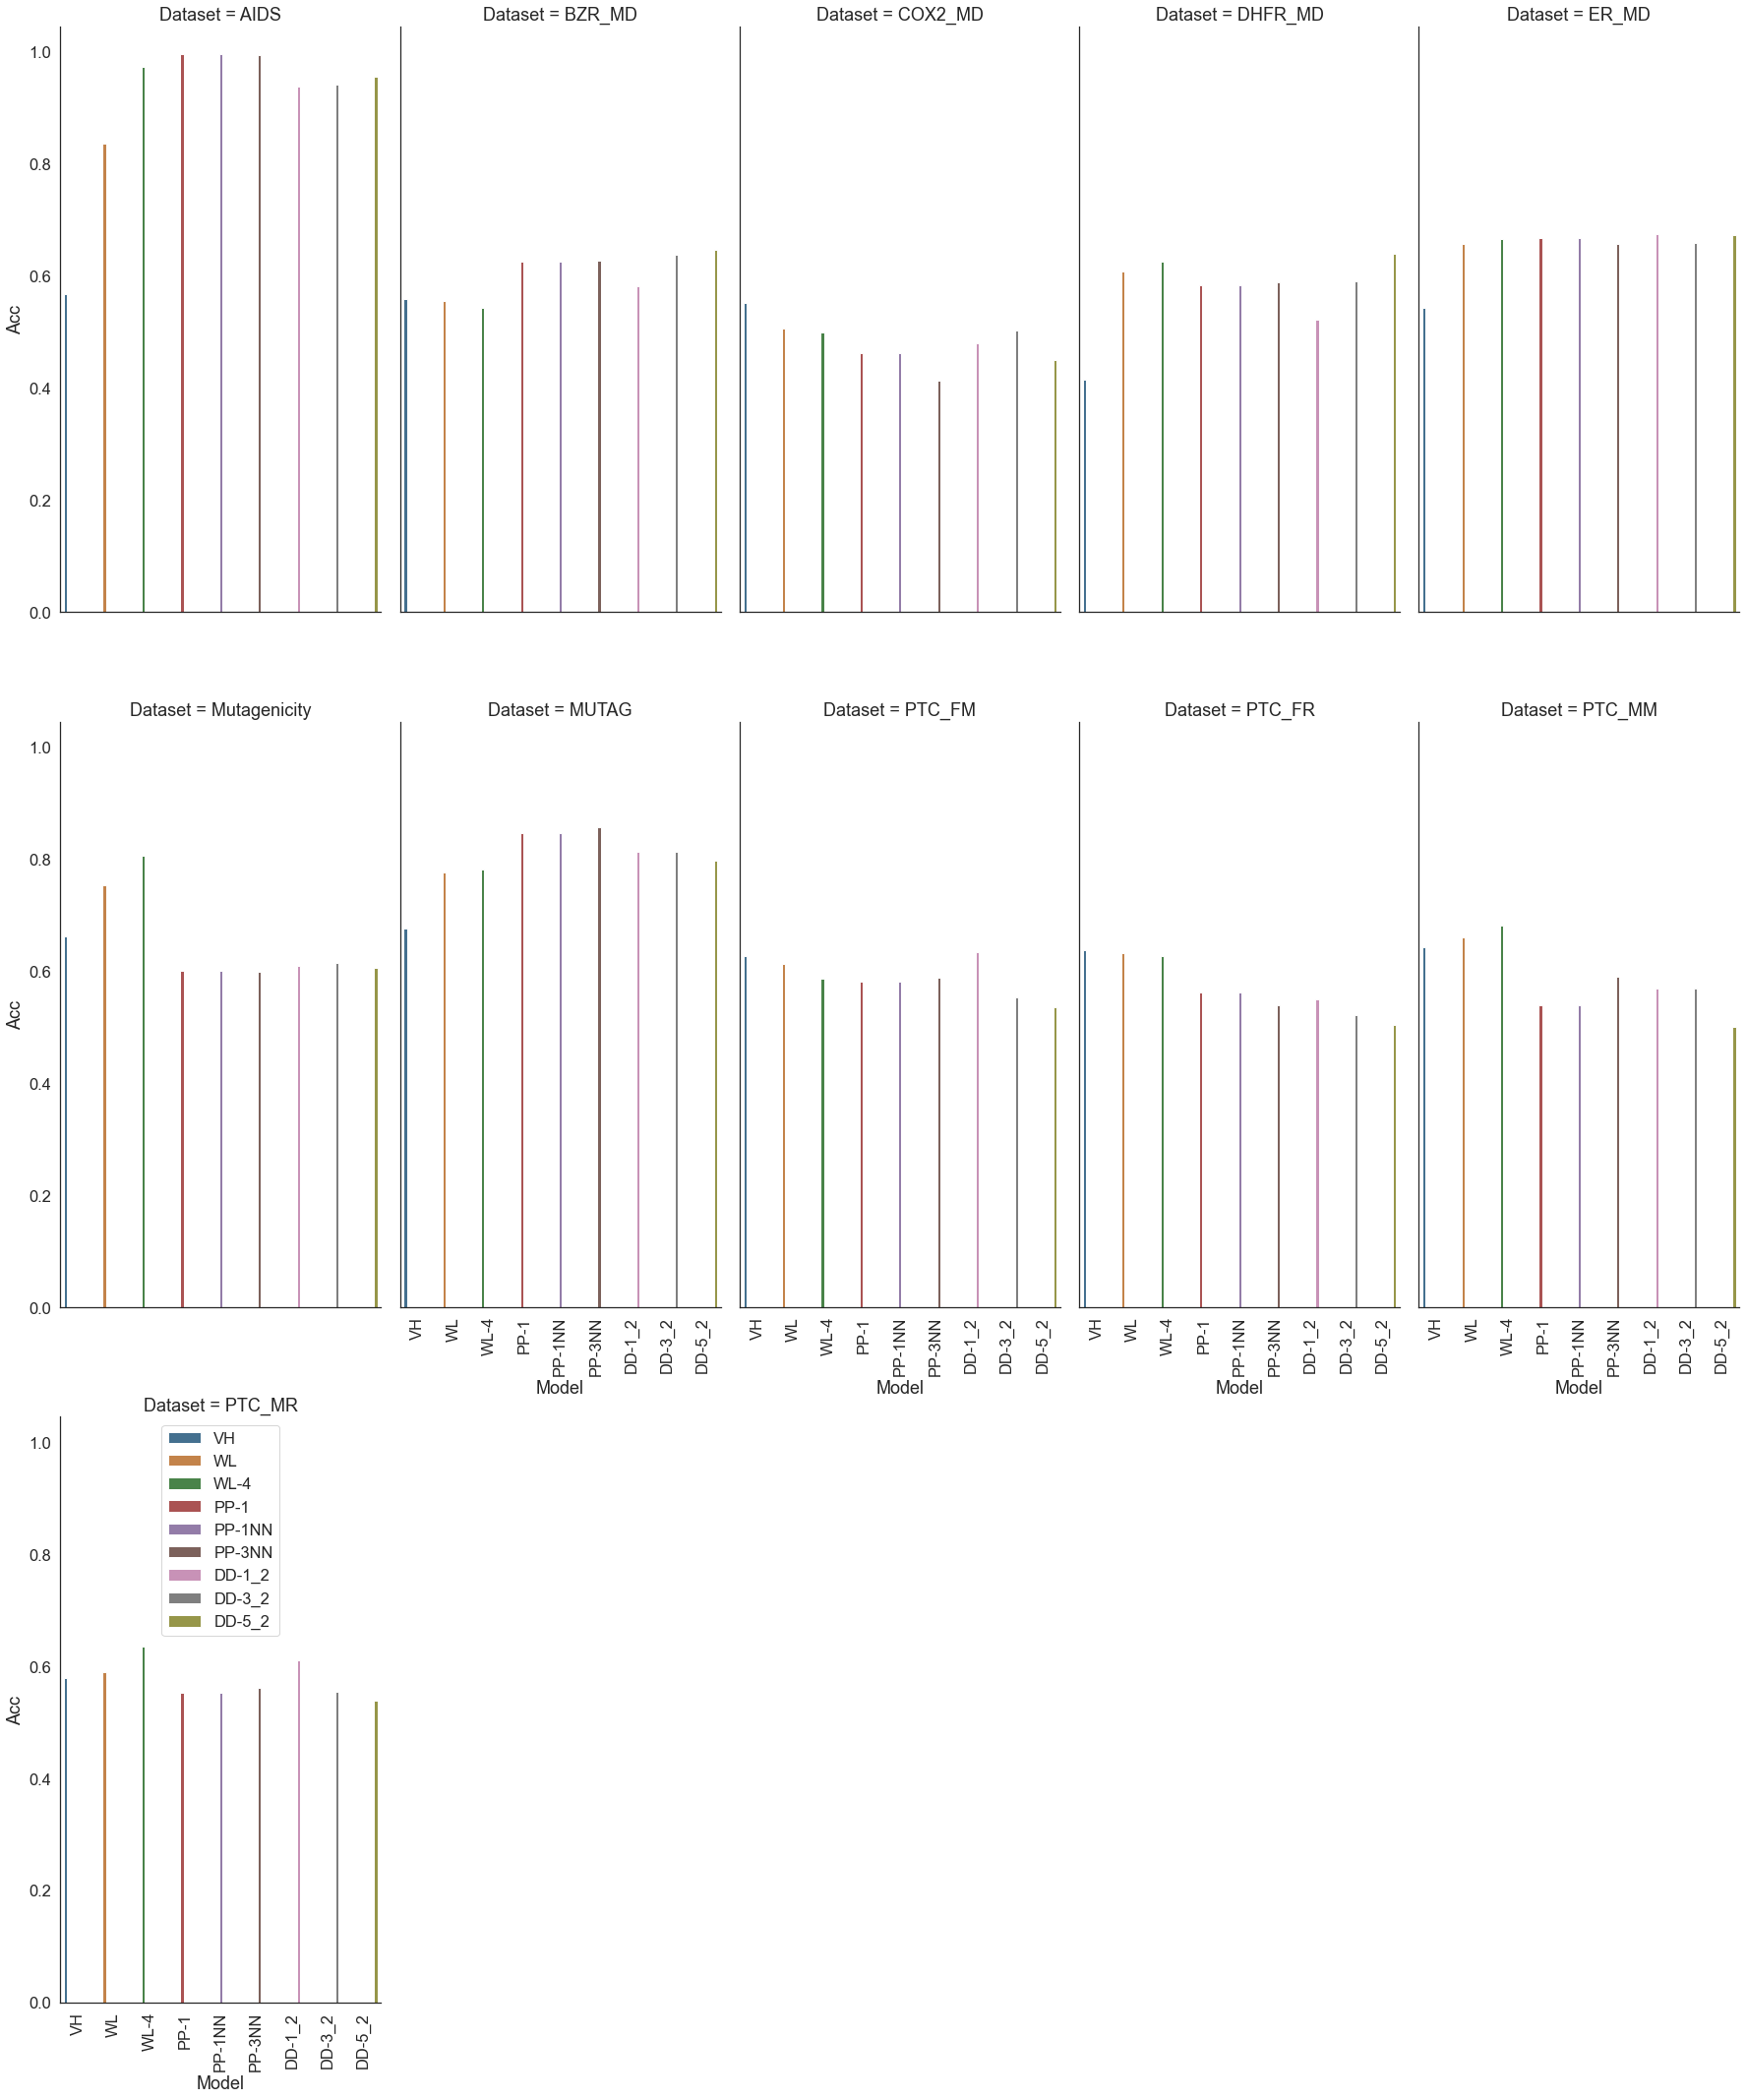

In [223]:
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="Acc", col="Dataset", hue="Model", sharey=True, col_wrap=5,
                data=res[['Dataset', 'Model', 'Acc']], saturation=.5, height=10,
                kind="bar", ci=None, aspect=0.5)

    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    plt.tight_layout()


In [ ]:
score_metric = 'F1_macro'
wins_time = np.zeros((len(model_names), len(model_names)))
wins_score = np.zeros((len(model_names), len(model_names)))
for dataset in wanted_dataset_names:
    subset = res[res['Dataset']==dataset].set_index('Model')
    for i, m1 in enumerate(model_names):
        for j, m2 in enumerate(model_names[:]):
            if subset.loc[m1][score_metric] > subset.loc[m2][score_metric]:
                wins_score[i,j] += 1
            elif subset.loc[m1][score_metric] < subset.loc[m2][score_metric]:
                wins_score[j, i] += 1
            else:
                pass

            if subset.loc[m1]['Time'] > subset.loc[m2]['Time']:
                wins_time[i,j] += 1
            elif subset.loc[m1]['Time'] < subset.loc[m2]['Time']:
                wins_time[j, i] += 1
            else:
                pass

In [ ]:
with sns.plotting_context(context='notebook', font_scale=1.2):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(pd.DataFrame(wins_score / (2*len(wanted_dataset_names)), columns = model_names, index=model_names), ax=ax, annot=True, fmt='.2f')
    plt.title(f'{score_metric} % wins/losses on {len(wanted_dataset_names)}')

In [ ]:
# melted = res.melt(id_vars=['Dataset', 'Model'], value_vars=['Acc', 'Acc_std', 'F1', "F1_std", 'Time'])
# with sns.plotting_context(context='notebook', font_scale=1.5):
#     #fig, ax = plt.subplots(1, 1, figsize=(20,10))
#     g = sns.catplot(x="variable", y="value", col="Dataset", hue='Model', sharey=False, col_wrap=4,
#                 data=melted, saturation=.5,
#                 kind="bar", ci=None, aspect=.6)

In [ ]:
res['dataset_rank'] = res.groupby(['Dataset'])['Acc'].rank(ascending=False)
res.groupby('Model').mean()

In [ ]:
np.unique(y_train)

In [ ]:
pd.DataFrame(results)

In [ ]:
prime_adj_train[1230]

In [ ]:
len(G_train), K_train.shape

In [ ]:

pp.transform([prime_adj_train[1229]])

In [ ]:
prime_adj_train[1229].shape[0]

In [ ]:
import networkx as nx
path = "/Users/Konstantinos.Bougiatiotis@ey.com/Downloads/LINUX/train/"
G = nx.read_gexf(path+"0.gexf")
type(G)

In [ ]:
G.edges(data=True)

In [ ]:
res[res['Dataset'] == 'PTC_MR']


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
dataset = fetch_dataset('PTC_MR', verbose=False, download_if_missing=True)
G, y = dataset.data, dataset.target
prime_adj_all = [get_prime_adjacency(g[2]) for g in  G]

from sklearn.model_selection import StratifiedKFold, GridSearchCV
param_grid = {'C': [10**p for p in [-3, -2, -1, 0, 1, 2, 3]],
              'kernel': ['rbf', 'linear', 'sigmoid']}
cv = StratifiedKFold(random_state=None, n_splits=10)
prime_adj_all_array = np.array(prime_adj_all, dtype='object')
acc = []
f1 = []
for train_indices, test_indices in cv.split(prime_adj_all, y):
    pp = ProductPower(power=1, normalize=True, grakel_compatible=False, kernel='rbf')
    X_train = prime_adj_all_array[train_indices]
    y_train = y[train_indices]
    X_test = prime_adj_all_array[test_indices]
    y_test = y[test_indices]
    X_train = pp.fit_transform(X_train, y_train)
    X_test = pp.transform(X_test)
    grid = GridSearchCV(SVC(), param_grid, refit = True, cv=10, verbose = 0, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_, grid.best_score_)
    y_pred = grid.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    print(f'Acc: {acc[-1]:.2f}, F1: {f1[-1]:.2f}')
    print('~'*50)
print(f'Acc: {100 * np.mean(acc):.2f} % ({np.std(acc):.2f})')
print(f'F1: {100 * np.mean(f1):.2f} % ({np.std(f1):.2f})')

In [ ]:
print(f'Acc: {100 * np.mean(acc):.2f} % ({np.std(acc):.2f})')
print(f'F1: {100 * np.mean(f1):.2f} % ({np.std(f1):.2f})')

# Work on Node classificaton IMDB multi-relational
https://www.ijcai.org/proceedings/2020/0175.pdf

THESE DID NOT WORK FOR IMDB, ACM, DBLP because of very trivial form of the datasets.
IMDB has two relations. Each node has exactly 1 r1 and 2 r2 to different nodes. So their product will be the same for all nodes.

Also, for all 3 datasets the 2-hop adjacency is all zeros (seems like disconeccted cases)


In [438]:
from scipy.sparse import csr_matrix, csc_matrix
def generate_prime_adj(data, wanted_indexes):

    rels = sorted(wanted_indexes)
    from sympy import nextprime
    relid2prime = {}
    prime2relid = {}
    current_int = 2
    for rel in rels:
        cur_prime = int(nextprime(current_int))
        relid2prime[rel] = cur_prime
        prime2relid[cur_prime] = rel
        current_int = cur_prime

    data_edges, rows, cols = [], [], []
    for rel_index in rels:
        #print(rel_index, len(data))

        rel_graph = data[rel_index]
        print(rel_graph.nnz)
        rows_ar, cols_ar = rel_graph.nonzero()
        rows.extend(rows_ar.tolist())
        cols.extend(cols_ar.tolist())
        data_edges.extend([relid2prime[rel_index] for _ in cols_ar])
    return csc_matrix((data_edges, (rows, cols)), dtype=int, shape=rel_graph.shape)


In [394]:
import pickle

In [490]:
# FOR IMDB we have 4 relation graphs. Rel graphs 0,1 are symmetric of each other and the same stands for 2,3.
# 0,1 correspond to relation 0 and 2,3 to relation 2.


path_edges = "/Users/Konstantinos.Bougiatiotis@ey.com/Downloads/data/DBLP/edges.pkl"
path_labels = "/Users/Konstantinos.Bougiatiotis@ey.com/Downloads/data/DBLP/labels.pkl"
with open(path_edges, 'rb') as f:
    data = pickle.load(f)
    print(f'Number of edge graphs {len(data)}')
    wanted_indexes = [0, 2]
    adj_ = generate_prime_adj(data, wanted_indexes).toarray()


node2label = np.zeros(adj_.shape[0]) - 1
node_splits = {}
with open(path_labels, 'rb') as f:
    data = pickle.load(f)
    for i, d in enumerate(data):
        unzipped = [item for item in  zip(*d)]
        node2label[np.array(unzipped[0])] = unzipped[1]
        if i == 0:
            case = 'train'
        elif i == 1:
            case = 'eval'
        else:
            case = 'test'
        cur_indexes = np.array(unzipped[0])
        cur_indexes.sort()
        print(f'Case: {case} | # of nodes: {len(cur_indexes)}')
        node_splits[case] = cur_indexes

Number of edge graphs 4
19645
14328
Case: train | # of nodes: 800
Case: eval | # of nodes: 400
Case: test | # of nodes: 2857


In [491]:
cur_feat = []
                cur_x = x.copy()
                # Power = 0 (1-hop, original Adjacency)
                cur_prod = np.sum(np.log(cur_x[cur_x >0]))

                if self.normalize:
                    cur_prod = cur_prod / ((n**2)*np.log(self.max_))
                cur_feat.append(cur_prod)
                for p in range(1, self.power):
                    cur_x = np.matmul(cur_x, x)
                    cur_prod = np.sum(np.log(cur_x[cur_x >0]))
                    if self.normalize:
                        cur_prod = cur_prod / ((n**2)*np.log(self.max_**p))
                    cur_prod -= cur_feat[-1]
                    cur_feat.append(cur_prod)
                x_tr.append(np.array(cur_feat))

IndentationError: unexpected indent (<ipython-input-491-599003987e56>, line 2)

In [499]:
class PrimeNodeTransfomer(TransformerMixin):

    def __init__(self, power=1):
        self.power = power

    def fit(self, X, y, adj):
        return self

    def fit_transform(self, X, y, adj):
        self.fit(X, y, adj)
        return self.transform(X=X, adj=adj)


    def transform(self, X, adj):
        cur_feat = []
        for p in range(0, self.power):
            if p == 0:
                cur_x = adj.copy()
            else:
                cur_x = np.multiply(cur_x, adj)
            print(p)
            cur_x_ones = cur_x.copy()
            print('copy')
            cur_x_ones[cur_x_ones == 0] = 1
            print('ones')
            vals = np.log(cur_x_ones).sum(axis=1)[X]
            print('log-sum')
            cur_feat.append(vals)
        return np.vstack(cur_feat)

pnt = PrimeNodeTransfomer(power=1)
pnt.fit_transform(node_splits['test'], node2label[node_splits['test']], adj_)

0
copy
ones
log-sum


array([[0., 0., 0., ..., 0., 0., 0.]])

In [498]:
adj_.sum()

130575

In [455]:
adj_2 = adj_ @ adj_
cop = adj_2[node_splits['eval'],:].copy()
cop.data = np.log(cop.data)
cop.sum(axis=1)

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [442]:
adj2_dense = np.multiply(adj_.todense(), adj_.todense())

In [454]:
adj2_dense[node_splits['train']]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [431]:
cop[10].nonzero(), cop[10].data

((array([0, 0], dtype=int32), array([  438, 18385], dtype=int32)),
 array([3, 5]))

In [432]:
cop[1].nonzero(), cop[1].data

((array([0, 0], dtype=int32), array([ 1945, 18385], dtype=int32)),
 array([3, 5]))

In [301]:
data[1][4661].nonzero()

(array([0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([   0,   25,  279,  282,  585, 2391, 3402], dtype=int32))

In [287]:
(data[2]!=data[3].T).nnz == 0

True

In [472]:
np.argsort(adj_.sum(axis=1).flatten())[::-1]

matrix([[    0,  2710,  2711, ..., 17758, 14882, 12278]])

In [ ]:
c = adj_.sum(axis=1).toarray()


AttributeError: 'matrix' object has no attribute 'toarray'

In [479]:
_, cols = adj_[17558].nonzero()

In [480]:
for c in cols:
    print(c, adj_[c].nnz)

949 0
3048 0
18402 0
